# Isolation Forest Model

### Model Training

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from joblib import dump

# Load your normal traffic dataset
normal_data = pd.read_csv("Normal traffic.csv")

# Encode categorical features
cat_cols = ['Protocol']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(normal_data[cat_cols])

# Create a dataframe for encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

# Combine encoded with numeric features
num_cols = normal_data.select_dtypes(include=[np.number]).columns
df_encoded = pd.concat([normal_data[num_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Fill missing values if any
df_encoded = df_encoded.fillna(0)

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)
print(df_encoded.columns)

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_scaled)

# Save model, encoder, and scaler
dump(model, "isolation_forest_ddos_model.joblib")
dump(encoder, "encoder_iso.joblib")
dump(scaler, "scaler_iso.joblib")

print("Isolation Forest model training completed and saved successfully.")


Index(['No.', 'Time', 'Length', 'Protocol_MQTT'], dtype='object')
Isolation Forest model training completed and saved successfully.


### Model Prediction and Evaluation

In [2]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Load mixed dataset (both normal and DDoS)
mixed_data = pd.read_csv("mixed_traffic_dataset.csv")

# Extract labels (if present)
labels = mixed_data['label'] if 'label' in mixed_data.columns else None

# Drop label column from features
if 'label' in mixed_data.columns:
    mixed_data = mixed_data.drop(columns=['label'])

# Load encoder and scaler
encoder = load("encoder_iso.joblib")
scaler = load("scaler_iso.joblib")

# Encode categorical features
cat_cols = ['Protocol']
encoded = encoder.transform(mixed_data[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

# Combine with numeric features
num_cols = mixed_data.select_dtypes(include=[np.number]).columns
X_mixed = pd.concat([mixed_data[num_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Fill missing values
X_mixed = X_mixed.fillna(0)

# Scale features
X_scaled = scaler.transform(X_mixed)

# Load trained model
model = load("isolation_forest_ddos_model.joblib")

# Predict anomalies
predictions = model.predict(X_scaled)
predictions = np.where(predictions == -1, 1, 0)  # 1 = anomaly (DDoS), 0 = normal

# Evaluate if labels exist
if labels is not None:
    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(labels, predictions))
    print("ROC AUC:", roc_auc_score(labels, predictions))
else:
    print("No labels found in dataset. Only predictions generated.")

# Save predictions
output = pd.DataFrame(X_mixed)
output['predicted_label'] = predictions
if labels is not None:
    output['true_label'] = labels.values
output.to_csv("mixed_predictions.csv", index=False)

print("Predictions saved as 'mixed_predictions.csv'.")


Confusion Matrix:
 [[33250  1750]
 [  470 35322]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     35000
           1       0.95      0.99      0.97     35792

    accuracy                           0.97     70792
   macro avg       0.97      0.97      0.97     70792
weighted avg       0.97      0.97      0.97     70792

ROC AUC: 0.9684342869915064
Predictions saved as 'mixed_predictions.csv'.


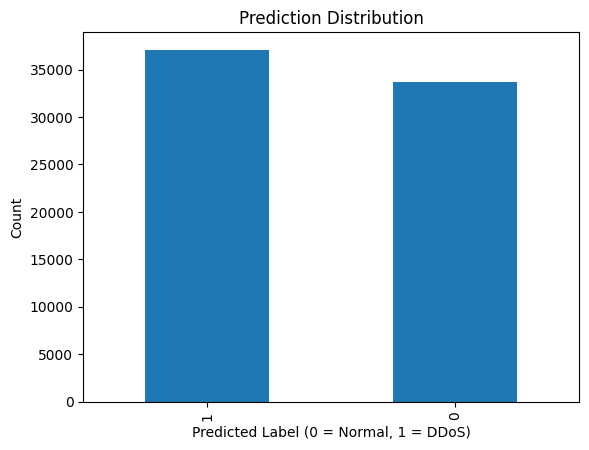

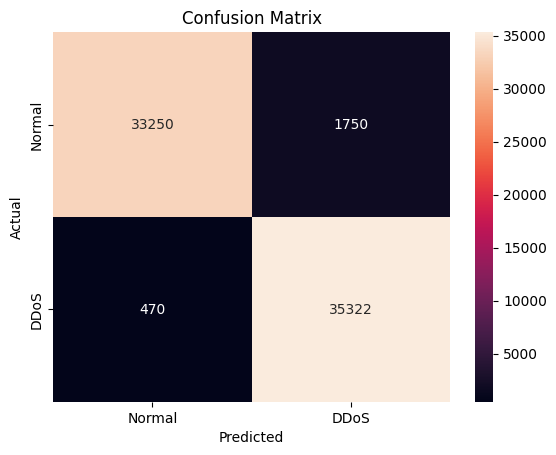

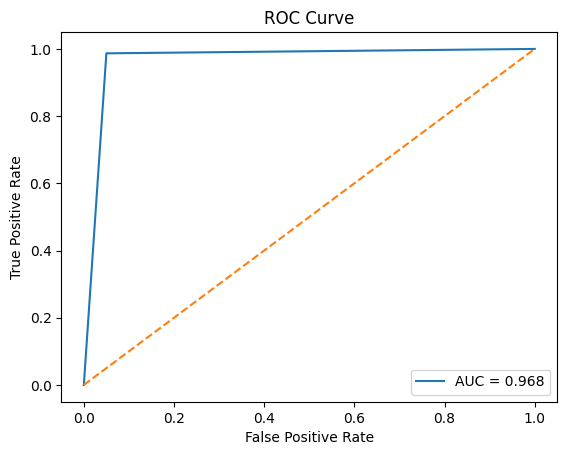

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load predictions file
df = pd.read_csv("mixed_predictions.csv")

# 1. Prediction distribution
plt.figure()
df['predicted_label'].value_counts().plot(kind='bar')
plt.xlabel("Predicted Label (0 = Normal, 1 = DDoS)")
plt.ylabel("Count")
plt.title("Prediction Distribution")
plt.show()

# Check if true labels exist
if 'true_label' in df.columns:

    # 2. Confusion Matrix
    cm = confusion_matrix(df['true_label'], df['predicted_label'])

    plt.figure()
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=['Normal', 'DDoS'],
        yticklabels=['Normal', 'DDoS']
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(df['true_label'], df['predicted_label'])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
